In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
from lib.utils import get_phi_psi_dist, find_kdepeak, find_kdepeak_af, calc_da
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'tests'

# When computing da, which cluster is chosen based on:
a. Most Likely
b. X-Ray
c. AlphaFold

- If not most likely, is it usually second most likely?

In [100]:
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from collections import defaultdict
bw_method = None
chosen_cluster = []
for protein in proteins:
    da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                           mode='kde_af')
    da.load_results()
    chosen_clusteri = defaultdict(list)

    for seq in da.seqs:
        print(protein, seq)
        phi_psi_dist,info = get_phi_psi_dist(da.queries, seq)
        af = da.phi_psi_predictions[(da.phi_psi_predictions.protein_id == da.alphafold_id) & (da.phi_psi_predictions.seq_ctxt == seq)]
        xray = da.xray_phi_psi[da.xray_phi_psi.seq_ctxt == seq]
        if af.shape[0] == 0 or xray.shape[0] == 0:    
            print(f'Skipping {seq}')
            continue
        xray = xray[['phi', 'psi']].values[0]
        af = af[['phi', 'psi']].values[0]
        print(phi_psi_dist.shape)
        
        phi_psi_dist = phi_psi_dist.loc[~phi_psi_dist[['phi', 'psi']].isna().any(axis=1)]
        if phi_psi_dist.shape[0] < 4:
            print(f'Skipping {seq}')
            continue

        bandwidth = 100
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms.fit(phi_psi_dist[['phi','psi']])
        phi_psi_dist['cluster'] = ms.labels_

        cluster_counts = phi_psi_dist.groupby('cluster').size()
        phi_psi_dist['cluster'] = phi_psi_dist['cluster'].apply(lambda x: x if cluster_counts[x] > 4 else -1)

        kdepeak = find_kdepeak(phi_psi_dist, bw_method)
        cluster_peaks = []
        probs = []
        for i in phi_psi_dist.cluster.unique():
            if i == -1:
                continue
            kdepeak_c,prob = find_kdepeak(phi_psi_dist[phi_psi_dist.cluster == i], bw_method, return_prob=True)
            # print(prob, kdepeak_c.values)
            probs.append(prob)
            cluster_peaks.append(kdepeak_c.values)
        cluster_peaks = np.array(cluster_peaks)[np.argsort(probs)][::-1]
        probs = np.sort(probs)[::-1]
        # print(probs)
        # print(cluster_peaks)

        print(f'\tFound {len(cluster_peaks)} Clusters')

        # Choose peak that is closest to AlphaFold prediction
        dists = calc_da(af, cluster_peaks)
        argmin = dists.argmin()
        # print(argmin, cluster_peaks[argmin])
        chosen_clusteri['af'].append(argmin)
        chosen_clusteri['af_prob'].append(probs[argmin])

        # Choose peak that is closest toX-ray prediction
        dists = calc_da(xray, cluster_peaks)
        argmin = dists.argmin()
        chosen_clusteri['xray'].append(argmin)
        chosen_clusteri['xray_prob'].append(probs[argmin])

        # Choose peak that would be PDBMine prediction - highest prob
        chosen_clusteri['pdbmine'].append(0)
        chosen_clusteri['pdbmine_prob'].append(probs[0])
    chosen_cluster.append(pd.DataFrame(chosen_clusteri).assign(protein=protein))
chosen_cluster = pd.concat(chosen_cluster)
chosen_cluster.to_csv('cluster_choice.csv', index=False)

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
T1024 GKEFWNL
Skipping GKEFWNL
T1024 KEFWNLD
(369, 5)
	Found 2 Clusters
T1024 EFWNLDK
(268, 5)
	Found 3 Clusters
T1024 FWNLDKN
(2362, 5)
	Found 2 Clusters
T1024 WNLDKNL
(2221, 5)
	Found 5 Clusters
T1024 NLDKNLQ
(3019, 5)
	Found 3 Clusters
T1024 LDKNLQL
(2552, 5)
	Found 1 Clusters
T1024 DKNLQLR
(1701, 5)
	Found 3 Clusters
T1024 KNLQLRL
(2776, 5)
	Found 4 Clusters
T1024 NLQLRLG
(2605, 5)
	Found 4 Clusters
T1024 LQLRLGI
(4215, 5)


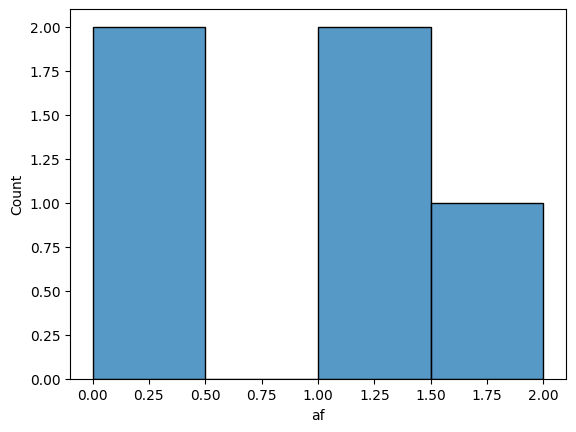

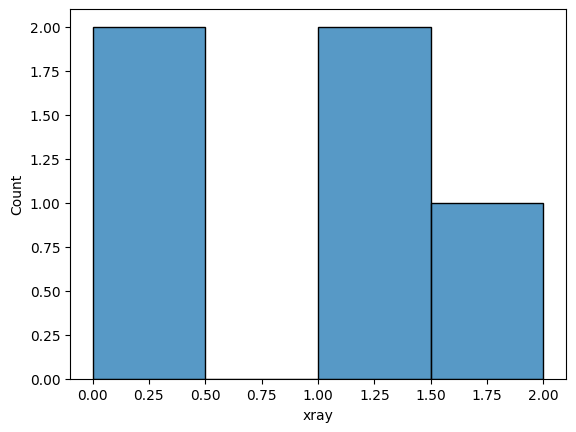

In [99]:
sns.histplot(chosen_cluster, x='af')
plt.show()
sns.histplot(chosen_cluster, x='xray')
plt.show()